# 통신사 고객 이탈 예측 

### 목적
* 파악한 특성들을 이용하여 기대 가치가 큰 고객의 이탈 징후를 잘 탐지하는 예측 모델 생성.
[참고](https://brunch.co.kr/@gimmesilver/53)
    - 예측 모델의 목표는 오차를 최소화하는 것이 아니다.
        - 실제 서비스에서 예측 모델을 사용하는 본질적인 목적은 정답을 잘 맞추겠다가 아니라 예측 모델을 실전에 적용함으로써 이익을 얻는 것. 
        - 따라서, 실제 예측 모델이 목표로 해야할 것은 오차를 최소화하는 것이 아니라 모델 적용을 통해 기대되는 이익을 최대화하는 것. 
        
### 문제 정의
* 지도학습, 분류

### 성능 지표
* 재현율
    * 실제 이탈하는 사람 중 이탈이라고 예측하는 것이 중요하기 때문.
    * 실제 이탈하지 않은 사람을 이탈이라고 예측하면 회사 측에서 손해액 발생

In [189]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder  # 더미변수 생성 

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import time

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # 분류
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns


In [2]:
df = pd.read_csv("../../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.shape

(7043, 21)

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
X = df.drop(["Churn"],axis = 1)
y = df["Churn"]

In [5]:
y.replace("No",0,inplace = True)
y.replace("Yes",1,inplace = True)

In [6]:
y.value_counts()/len(y)

0    0.73463
1    0.26537
Name: Churn, dtype: float64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify = y,test_size = 0.2, shuffle = True, random_state = 20171490)

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5634, 20)
(1409, 20)
(5634,)
(1409,)


#### train데이터로만 탐색

In [9]:
data_train = X_train

In [10]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 5658 to 1059
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5634 non-null   object 
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   int64  
 3   Partner           5634 non-null   object 
 4   Dependents        5634 non-null   object 
 5   tenure            5634 non-null   int64  
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  PaperlessBilling  5634 non-null   objec

In [11]:
data_train["SeniorCitizen"] = data_train["SeniorCitizen"].astype("object")
data_train["TotalCharges"] = pd.to_numeric(data_train["TotalCharges"],errors = 'coerce')

In [12]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 5658 to 1059
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5634 non-null   object 
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   object 
 3   Partner           5634 non-null   object 
 4   Dependents        5634 non-null   object 
 5   tenure            5634 non-null   int64  
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  PaperlessBilling  5634 non-null   objec

In [13]:
cate_features2 = []
cate_features_not2 = []

for column in data_train.columns:
    if data_train[column].dtypes==object:
        if len(data_train[column].value_counts())==2:
            cate_features2.append(column)
        else:
            cate_features_not2.append(column)
        
print(cate_features2)
print(cate_features_not2)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
['customerID', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']


In [14]:
cate_features2_for = cate_features2[2:]
cate_features2_for

['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

In [15]:
data_train["gender"].replace("Female",1,inplace=True)
data_train["gender"].replace("Male",0,inplace=True)

In [16]:
for column in cate_features2_for:
    data_train[column] = data_train[column].replace("Yes",1)
    data_train[column] = data_train[column].replace("No",0)

In [17]:
data_train = data_train.drop(["customerID","TotalCharges"], axis = 1)

In [21]:
num_features = ["tenure","MonthlyCharges"]

array([[<AxesSubplot:title={'center':'tenure'}>,
        <AxesSubplot:title={'center':'MonthlyCharges'}>]], dtype=object)

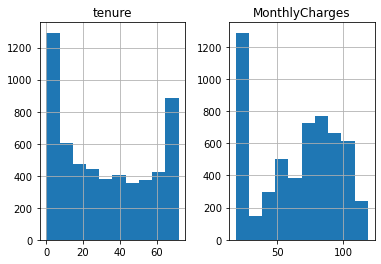

In [22]:
data_train[num_features].hist()

array([[<AxesSubplot:title={'center':'tenure'}>,
        <AxesSubplot:title={'center':'MonthlyCharges'}>]], dtype=object)

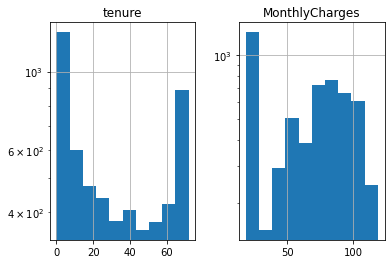

In [23]:
data_train[num_features].hist(log=True)

In [24]:
print(cate_features_not2)
print(num_features)

['customerID', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
['tenure', 'MonthlyCharges']


In [25]:
cate_features_not2.remove("customerID")

scaler_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', MinMaxScaler(feature_range=(0,1))),
])

In [26]:
data_train.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges'],
      dtype='object')

In [27]:
selector = ColumnTransformer([
    ('one_hot', OneHotEncoder(), cate_features_not2), # 나열되지 않은 나머지 열은 삭제됨. 
    ('scaler', scaler_pipeline, num_features),
],remainder="passthrough")

X_prepared = selector.fit_transform(data_train)

In [28]:
pd.DataFrame(X_prepared)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0,0,1,0,1,0,1,0,0,1,...,1,0,0.333333,0.743781,0,0,1,0,1,1
1,0,0,1,0,1,0,1,0,0,0,...,0,0,0.486111,0.667164,1,0,0,0,1,0
2,1,0,0,0,1,0,1,0,0,0,...,0,1,0.180556,0.561194,1,0,0,0,1,1
3,1,0,0,0,0,1,0,1,0,0,...,0,1,0.583333,0.0243781,0,0,1,1,1,0
4,0,1,0,1,0,0,1,0,0,1,...,0,1,0.0555556,0.0597015,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,1,0,0,0,0,1,0,1,0,0,...,0,1,0.0833333,0.0144279,0,0,0,1,1,0
5630,0,0,1,1,0,0,0,0,1,0,...,0,0,0.916667,0.489552,1,0,1,1,1,1
5631,0,0,1,0,1,0,1,0,0,1,...,0,0,0.916667,0.81393,0,1,1,0,1,1
5632,0,0,1,1,0,0,0,0,1,0,...,0,0,0.972222,0.714428,0,1,1,0,1,0


#### 파이프라인 적용 후 feature 확인

In [29]:
cat_encoder = selector.named_transformers_["one_hot"]

cat_one_hot_features = []

i = 0
for feature in cate_features_not2:
    cat_one_hot_features.append([feature+"_"+string for string in list(cat_encoder.categories_[i])])    
    
    i+=1

cat_one_hot_features = sum(cat_one_hot_features,[])
print(cat_one_hot_features)

features = cat_one_hot_features + num_features + cate_features2 
print(len(features))

['MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']
39


In [30]:
X_prepared.shape

(5634, 39)

### 여러 모델 적용하여 비교하기 

In [31]:
models = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier(), AdaBoostClassifier(), XGBClassifier()]
names = ["Logistic","RF","GB","Ada","XGB"]

from sklearn.model_selection import StratifiedKFold
cv_mo = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 20171490)

for model, name in zip(models, names):
    print(name)
    start = time.time()
    cv_predict = cross_val_predict(model, X_prepared, y_train,cv=cv_mo)

    print(classification_report(y_train, cv_predict))
    print("--------------------------------------")

Logistic
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      4139
           1       0.65      0.55      0.59      1495

    accuracy                           0.80      5634
   macro avg       0.75      0.72      0.73      5634
weighted avg       0.79      0.80      0.80      5634

--------------------------------------
RF
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      4139
           1       0.61      0.49      0.54      1495

    accuracy                           0.78      5634
   macro avg       0.72      0.69      0.70      5634
weighted avg       0.77      0.78      0.77      5634

--------------------------------------
GB
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4139
           1       0.65      0.53      0.58      1495

    accuracy                           0.80      5634
   macro avg       0.75      0.71  

AdaBoost와 Logistic의 성능이 가장 좋음

#### 랜덤포레스트기로 중요 변수 확인

In [32]:
feature_importances = pd.DataFrame(RandomForestClassifier().fit(X_prepared,y_train).feature_importances_,index = features,columns=['importance']).sort_values('importance',ascending=False)
feature_importances = feature_importances.head(10)
feature_importances

,importance
tenure,0.207441
MonthlyCharges,0.201000
Contract_Month-to-month,0.060925
OnlineSecurity_No,0.034036
gender,0.033720
InternetService_Fiber optic,0.033041
Partner,0.027970
PaperlessBilling,0.027919
TechSupport_No,0.026773
PaymentMethod_Electronic check,0.026260


<AxesSubplot:xlabel='importance'>

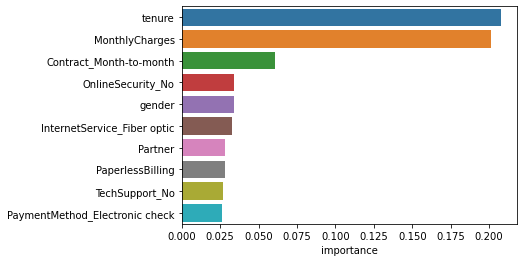

In [37]:
sns.barplot(feature_importances["importance"],feature_importances.index)

#### 보조 서비스 가입 개수 변수 추가하기
보조서비스 종류: OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport   
스트리밍: StreamingTV, StreamingMovies

In [38]:
data_train["OnlineSecurity"].value_counts()

No                     2786
Yes                    1626
No internet service    1222
Name: OnlineSecurity, dtype: int64

In [39]:
df_new = data_train[["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]]

In [40]:
df_new.replace("Yes",1,inplace = True)
df_new.replace("No",0, inplace = True)
df_new.replace("No internet service",0, inplace = True)

In [41]:
df_new.head()

,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
5658,0,0,0,0,1,1
995,0,1,0,1,0,0
2778,0,1,0,0,0,0
2675,0,0,0,0,0,0
660,0,0,0,0,0,0


In [42]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 5658 to 1059
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   OnlineSecurity    5634 non-null   int64
 1   OnlineBackup      5634 non-null   int64
 2   DeviceProtection  5634 non-null   int64
 3   TechSupport       5634 non-null   int64
 4   StreamingTV       5634 non-null   int64
 5   StreamingMovies   5634 non-null   int64
dtypes: int64(6)
memory usage: 308.1 KB


In [43]:
data_train["supplementarty_service"] = df_new["OnlineSecurity"]+df_new["OnlineBackup"]+df_new["DeviceProtection"]+df_new["TechSupport"]
data_train["Streaming"] = df_new["StreamingTV"]+df_new["StreamingMovies"]

In [44]:
data_train = data_train.drop(["OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies"],axis=1)
data_train.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'supplementarty_service', 'Streaming'],
      dtype='object')

In [45]:
num_features_extract = num_features+["supplementarty_service","Streaming"]
# num_features_extract = num_features+["supplementarty_service"]

In [46]:
cate_features2

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling']

In [47]:
cate_features_extract = ["MultipleLines","InternetService","Contract","PaymentMethod"]

In [48]:
print(num_features_extract)
print(cate_features_extract)

['tenure', 'MonthlyCharges', 'supplementarty_service', 'Streaming']
['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod']


In [49]:
selector = ColumnTransformer([
    ('one_hot', OneHotEncoder(), cate_features_extract),  # 나열되지 않은 나머지 열은 삭제됨. 
    ('scaler', scaler_pipeline, num_features_extract)
],remainder="passthrough")

X_prepared = selector.fit_transform(data_train)

In [50]:
X_prepared.shape

(5634, 23)

In [51]:
models = [LogisticRegression(), RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1), GradientBoostingClassifier(), AdaBoostClassifier(), XGBClassifier()]
names = ["Logistic","RF","GB","Ada","XGB"]

cv_mo = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 20171490)

for model, name in zip(models, names):
    print(name)
    start = time.time()
    
    # method{'predict’,'predict_proba’, 'predict_log_proba’, 'decision_function'}, default=’predict’
    cv_predict = cross_val_predict(model, X_prepared, y_train,cv=cv_mo)

    print(classification_report(y_train, cv_predict))
    print("--------------------------------------")

Logistic
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4139
           1       0.66      0.55      0.60      1495

    accuracy                           0.81      5634
   macro avg       0.75      0.73      0.74      5634
weighted avg       0.80      0.81      0.80      5634

--------------------------------------
RF
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      4139
           1       0.68      0.47      0.55      1495

    accuracy                           0.80      5634
   macro avg       0.75      0.69      0.71      5634
weighted avg       0.79      0.80      0.79      5634

--------------------------------------
GB
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4139
           1       0.65      0.53      0.58      1495

    accuracy                           0.80      5634
   macro avg       0.74      0.71  

In [52]:
cate_features_extract

['MultipleLines', 'InternetService', 'Contract', 'PaymentMethod']

In [53]:
cat_encoder = selector.named_transformers_["one_hot"]

cat_one_hot_features = []

i = 0
for feature in cate_features_extract:
    cat_one_hot_features.append([feature+"_"+string for string in list(cat_encoder.categories_[i])])    
    
    i+=1

cat_one_hot_features = sum(cat_one_hot_features,[])
print(cat_one_hot_features)

features = cat_one_hot_features + num_features_extract + cate_features2 
print(features)
print(len(features))

['MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']
['MultipleLines_No', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_DSL', 'InternetService_Fiber optic', 'InternetService_No', 'Contract_Month-to-month', 'Contract_One year', 'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'tenure', 'MonthlyCharges', 'supplementarty_service', 'Streaming', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
23


In [54]:
feature_importances = pd.DataFrame(RandomForestClassifier().fit(X_prepared,y_train).feature_importances_,index = features,columns=['importance']).sort_values('importance',ascending=False)
feature_importances = feature_importances.head(10)
feature_importances

,importance
MonthlyCharges,0.246296
tenure,0.239657
Contract_Month-to-month,0.067602
supplementarty_service,0.064340
InternetService_Fiber optic,0.039167
Streaming,0.034963
gender,0.033864
PaymentMethod_Electronic check,0.031942
PaperlessBilling,0.030779
Partner,0.028719


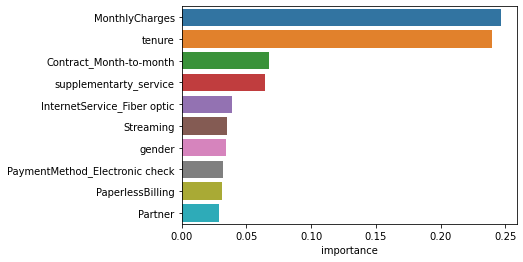

In [55]:
bar = sns.barplot(feature_importances["importance"],feature_importances.index)

In [232]:
from sklearn.model_selection import GridSearchCV

param_grid_logistic = {
    "C":[0.25,0.5,0.75,1.0,1.5,2.0],
    "solver":["lbfgs", "sag", "saga"],
    "tol":[0.01,0.001],
    "penalty":["l1","l2"]}

cv_logistic = GridSearchCV(LogisticRegression(),param_grid_logistic, cv= cv_mo, scoring = "recall")
cv_logistic.fit(X_prepared, y_train)  # grid search 모델 
cv_logistic_best = cv_logistic.best_estimator_  # 가장 좋은 파라미터
print(cv_logistic_best)

LogisticRegression(C=1.5, solver='saga', tol=0.01)


In [233]:
cv_logistic.score(X_prepared, y_train)

0.5591973244147157

In [234]:
cv_predict = cross_val_predict(cv_logistic, X_prepared, y_train,cv=cv_mo)
print(classification_report(y_train, cv_predict))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      4139
           1       0.66      0.55      0.60      1495

    accuracy                           0.80      5634
   macro avg       0.75      0.72      0.74      5634
weighted avg       0.80      0.80      0.80      5634



In [ ]:

param_grid_logistic = {
    "C":[0.25,0.5,0.75,1.0,1.5,2.0],
    "solver":["lbfgs", "sag", "saga"],
    "tol":[0.01,0.001],
    "penalty":["l1","l2"]}

cv_logistic = GridSearchCV(LogisticRegression(),param_grid_logistic, cv= cv_mo, scoring = "roc_auc")
cv_logistic.fit(X_prepared, y_train)  # grid search 모델 
cv_logistic_best = cv_logistic.best_estimator_  # 가장 좋은 파라미터
print(cv_logistic_best)

In [ ]:
cv_logistic.score(X_prepared, y_train)

In [ ]:
print(confusion_matrix(y_train,cv_logistic.predict(X_prepared)))
print(classification_report(y_train,cv_logistic.predict(X_prepared)))

In [ ]:
from sklearn.metrics import recall_score, make_scorer

custom_scorer = make_scorer(precision_score, greater_is_better=True,  pos_label=1)
cv_logistic = GridSearchCV(LogisticRegression(),param_grid_logistic, cv= cv_mo, scoring = custom_scorer)
cv_logistic.fit(X_prepared, y_train)  # grid search 모델 
cv_logistic_best = cv_logistic.best_estimator_  # 가장 좋은 파라미터
print(cv_logistic_best)

In [ ]:
pd.DataFrame(cv_logistic.cv_results_)["mean_test_score"].sort_values(ascending =True)

In [ ]:
print(confusion_matrix(y_train,cv_logistic.predict(X_prepared)))
print(classification_report(y_train,cv_logistic.predict(X_prepared)))

In [ ]:
pred = cross_val_predict(cv_logistic_best,X_prepared,y_train,cv = cv_mo)
print(classification_report(y_train,cv_logistic.predict(X_prepared)))

In [62]:
param_grid_RF = {
    "n_estimators" :[10,15,20,25,30], 
    "criterion": ["entropy","gini"],
    "max_depth" : [5,10,15],
    "min_samples_split":[2,4,8,16],
    "max_features":["sqrt","auto","log2"],
    "class_weight" : ["balanced_subsample","balanced"]}

cv_RF_roc = GridSearchCV(RandomForestClassifier(),param_grid_RF, cv= cv_mo, scoring = "roc_auc")
cv_RF_roc.fit(X_prepared, y_train)
cv_RF_best = cv_RF_roc.best_estimator_

print(cv_RF.score(X_prepared, y_train))
print(confusion_matrix(cv_RF.predict(X_prepared),y_train))
print(classification_report(cv_RF.predict(X_prepared),y_train))

0.9070812671052174
[[3242  208]
 [ 897 1287]]
              precision    recall  f1-score   support

           0       0.78      0.94      0.85      3450
           1       0.86      0.59      0.70      2184

    accuracy                           0.80      5634
   macro avg       0.82      0.76      0.78      5634
weighted avg       0.81      0.80      0.79      5634



In [157]:
cv_RF_best

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, max_features='sqrt', min_samples_split=16,
                       n_estimators=30)

In [63]:
model_Ada = AdaBoostClassifier(base_estimator = cv_RF_best, n_estimators = 4)
model_Ada.fit(X_prepared, y_train)
print(confusion_matrix(model_Ada.predict(X_prepared),y_train))
print(classification_report(model_Ada.predict(X_prepared),y_train))

[[3468  105]
 [ 671 1390]]
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      3573
           1       0.93      0.67      0.78      2061

    accuracy                           0.86      5634
   macro avg       0.88      0.82      0.84      5634
weighted avg       0.87      0.86      0.86      5634



In [64]:
param_XGB = {"max_depth" : [3,4,5,6,7],
    "learning_rate" : [0.01, 0.05, 0.001],
    "booster" : ["gbtree","gblinear","dart"],
    "min_child_weight" : [1,3,5,7,9,11],
    "scale_pos_weight":[1,3,5]}

cv_xgb = GridSearchCV(XGBClassifier(),param_XGB, cv= cv_mo, scoring = "recall")
cv_xgb.fit(X_prepared, y_train)
cv_xgb_best_recall = cv_xgb.best_estimator_

In [65]:
print(cv_xgb.score(X_prepared, y_train))
print(confusion_matrix(y_train,cv_xgb.predict(X_prepared)))
print(classification_report(y_train,cv_xgb.predict(X_prepared)))

0.9926421404682274
[[ 921   11]
 [3218 1484]]
              precision    recall  f1-score   support

           0       0.22      0.99      0.36       932
           1       0.99      0.32      0.48      4702

    accuracy                           0.43      5634
   macro avg       0.61      0.65      0.42      5634
weighted avg       0.87      0.43      0.46      5634



In [66]:
param_XGB = {"max_depth" : [3,4,5,6,7],
    "learning_rate" : [0.01, 0.05, 0.001],
    "booster" : ["gbtree","gblinear","dart"],
    "min_child_weight" : [1,3,5,7,9,11],
    "scale_pos_weight":[1,3,5]}

xgb_model = xgb.XGBClassifier(objective = "binary:logistic")

cv_xgb = GridSearchCV(xgb_model,param_XGB, cv= cv_mo, scoring = "roc_auc")
cv_xgb.fit(X_prepared, y_train)
cv_xgb_best_roc = cv_xgb.best_estimator_

print(cv_xgb.score(X_prepared, y_train))
print(confusion_matrix(y_train,cv_xgb.predict(X_prepared)))
print(classification_report(y_train,cv_xgb.predict(X_prepared)))

0.86505731838673
[[3769  689]
 [ 370  806]]
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      4458
           1       0.54      0.69      0.60      1176

    accuracy                           0.81      5634
   macro avg       0.72      0.77      0.74      5634
weighted avg       0.83      0.81      0.82      5634



xgb 0.69로 가장 높음.

In [193]:
# Dictionary of best parameters
best_pars = cv_xgb.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = cv_xgb.best_estimator_

import pickle
# Save model
pickle.dump(cv_xgb.best_estimator_, open("xgb_clf.pickle", "wb"))

In [203]:
from sklearn.metrics import precision_recall_curve

best_model.fit(X_prepared,y_train)
pred = best_model.predict(X_prepared)

In [205]:
cv_predict_best = cross_val_predict(best_model, X_prepared, y_train,cv=cv_mo)

In [212]:
print(confusion_matrix(y_train,cv_predict_best))

[[3739  400]
 [ 713  782]]


In [209]:
print(classification_report(y_train,cv_predict_best))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4139
           1       0.66      0.52      0.58      1495

    accuracy                           0.80      5634
   macro avg       0.75      0.71      0.73      5634
weighted avg       0.79      0.80      0.79      5634



In [ ]:
print(classification_report(y_train, model_xgb.predict(X_prepared)))

In [172]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train,y_scores_forest)

In [176]:
y_train_pred_forest = cross_val_predict(model_xgb, X_prepared, y_train, cv=cv_mo)

In [211]:
print(precision_score(y_train, cv_predict_best))
print(recall_score(y_train, cv_predict_best))

0.6615905245346869
0.5230769230769231


In [ ]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

In [ ]:
thresholds

In [ ]:
len(thresholds)

In [ ]:
precision_90_recall = precisions[np.argmax(recalls >= 0.90)]
threshold_90_precision = thresholds[np.argmax(recalls >= 0.90)]

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center left", fontsize=10) 
    plt.xlabel("Threshold", fontsize=13)        
    plt.grid(True)                              
    plt.axis([-20, 5, 0, 1])             

In [ ]:
plt.figure(figsize=(8, 4))                                                                 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [ ]:
import matplotlib.pyplot as plt

def plot_precision_vs_recall(recalls, precisions):
    plt.plot(precisions,recalls, "b-", linewidth=2)
    plt.xlabel("Precision", fontsize=16)
    plt.ylabel("Recall", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(recalls, precisions)


In [ ]:
recalls

In [ ]:
threshold_80_recall = thresholds[np.argmax(recalls <= 0.80)]
threshold_80_recall

In [ ]:
y_train_pred_80 = (y_scores >= threshold_80_recall)

In [ ]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train, y_train_pred_80))
print(recall_score(y_train, y_train_pred_80))

#### 데이터가 불균형하기 때문에 업샘플링을 통해 비율을 맞춤. 

In [238]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 12)
x_res, y_res = sm.fit_sample(X_prepared, y_train)
print(y_train.value_counts(), np.bincount(y_res))

0    4139
1    1495
Name: Churn, dtype: int64 [4139 4139]


In [248]:
models = [LogisticRegression(), RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1), GradientBoostingClassifier(), AdaBoostClassifier(), XGBClassifier()]
names = ["Logistic","RF","GB","Ada","XGB"]

cv_mo = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 20171490)

for model, name in zip(models, names):
    print(name)
    start = time.time()
    
    # method{'predict’,'predict_proba’, 'predict_log_proba’, 'decision_function'}, default=’predict’
    cv_predict = cross_val_predict(model, x_res, y_res,cv=cv_mo)

    print(classification_report(y_res, cv_predict))
    print("--------------------------------------")

Logistic
              precision    recall  f1-score   support

           0       0.79      0.75      0.77      4139
           1       0.76      0.81      0.78      4139

    accuracy                           0.78      8278
   macro avg       0.78      0.78      0.78      8278
weighted avg       0.78      0.78      0.78      8278

--------------------------------------
RF
              precision    recall  f1-score   support

           0       0.83      0.74      0.78      4139
           1       0.76      0.85      0.81      4139

    accuracy                           0.80      8278
   macro avg       0.80      0.80      0.79      8278
weighted avg       0.80      0.80      0.79      8278

--------------------------------------
GB
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      4139
           1       0.82      0.87      0.84      4139

    accuracy                           0.84      8278
   macro avg       0.84      0.84  

업샘플링을 통해 0.86으로 성능 올라감. 

In [254]:
param_XGB = {"max_depth" : [3,4,5,6,7],
    "learning_rate" : [0.01, 0.05, 0.001],
    "booster" : ["gbtree","gblinear","dart"],
    "min_child_weight" : [1,3,5,7,9,11],
    "scale_pos_weight":[1,3,5]}

cv_xgb = GridSearchCV(XGBClassifier(),param_XGB, cv= cv_mo, scoring = "roc_auc")
cv_xgb.fit(x_res, y_res)
cv_xgb_best_roc = cv_xgb.best_estimator_

print(cv_xgb.score(x_res, y_res))
print(confusion_matrix(y_res,cv_xgb.predict(x_res)))
print(classification_report(y_res,cv_xgb.predict(x_res)))

0.9549238497136328
[[3510  629]
 [ 378 3761]]
              precision    recall  f1-score   support

           0       0.90      0.85      0.87      4139
           1       0.86      0.91      0.88      4139

    accuracy                           0.88      8278
   macro avg       0.88      0.88      0.88      8278
weighted avg       0.88      0.88      0.88      8278



In [259]:
cv_xgb_best.fit(x_res,y_res)
print(recall_score(y_res, cv_xgb_best.predict(x_res)))
print(classification_report(y_res,cv_xgb_best.predict(x_res)))

0.8719497463155351
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      4139
           1       0.80      0.87      0.83      4139

    accuracy                           0.83      8278
   macro avg       0.83      0.83      0.83      8278
weighted avg       0.83      0.83      0.83      8278



In [257]:
pred = cross_val_predict(cv_xgb_best_roc,x_res,y_res, cv = 10)
print(classification_report(y_res,pred))

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      4139
           1       0.83      0.87      0.85      4139

    accuracy                           0.84      8278
   macro avg       0.85      0.84      0.84      8278
weighted avg       0.85      0.84      0.84      8278

